## Import Libraries

In [1]:
import pandas as pd
import seaborn
import matplotlib.pyplot as plt
import os

### Global Configs

In [2]:
results_folder = '../logs/'

### A simple object to parse one log file

In [3]:
class Experiment:
    
    def __init__(self, experiment, results_folder):
        """
            Takes in an experiment string like:
                experiment = 'exp_6__1_10_10000__1e-06__20200706192647.csv'
            And builds an object with the experiment configuration. 
        """
        experiment_csv = f"{results_folder}{experiment}"
        assert os.path.exists(experiment_csv)

        experiment_config = experiment.split('__')

        # Make sure the experiment configuration is as expected
        assert len(experiment_config) == 4
        experiment_number, game_parameters, learning_rate, timestamp = experiment_config
        game_parameters = game_parameters.split('_')

        # Make sure the game parameters are as expected
        assert len(game_parameters) == 3
        game_length, num_trajs, num_epo = game_parameters

        # Read the first line of the results file to get the name of the policies of the two agents. 
        with open(experiment_csv, 'r') as file:
            policies_names = file.readline().strip().split(',')
            # Assume that there are only two agents
            assert len(policies_names) == 2
            agent_1_policy, agent_2_policy = policies_names

        # Collect all the experiment configuration into one dictionary
        self.experiment_config = {
            'results_folder' : results_folder,
            'experiment' : experiment,
            'experiment_csv' : experiment_csv,
            'experiment_number' : experiment_number,
            'game_length' : int(game_length),
            'num_trajs' : int(num_trajs),
            'num_epo' : int(num_epo),
            'learning_rate' : float(learning_rate),                 
            'timestamp' : timestamp,                     
            'agent_1_policy' : agent_1_policy,
            'agent_2_policy' : agent_2_policy}
    
    def get_experiment_data(self):
        """ Read the .csv file"""
        if self.experiment_config is not None:
            if 'data' not in self.experiment_config:    
                self.experiment_config['data'] = pd.read_csv(self.experiment_config['experiment_csv'], 
                                                             skiprows=1, 
                                                             header=None, 
                                                             names=['avg_agent_1','std_agent_1', 
                                                                    'avg_agent_2','std_agent_2'])
        return self.experiment_config['data']
    
    def __repr__(self):
        return f"{self.experiment_config['experiment']}"
    
    @staticmethod
    def partition_experiments(comparator, results_folder):
        """
            Partition the experiments folder into equivalence classes. 
        """
        list_of_expts = [Experiment(expt_csv, results_folder) for expt_csv in os.listdir(results_folder)]
        partition = []
        while len(list_of_expts) > 0:
            current_exp = list_of_expts[0]
            partition += [list(filter(lambda e, cur=current_exp: comparator(e, cur), list_of_expts))]
            list_of_expts = list(filter(lambda e, cur=current_exp: not comparator(e, cur), list_of_expts))
        return partition        

    @staticmethod
    def equal_game_params(e1, e2):
        return e1.experiment_config['game_length'] == e2.experiment_config['game_length'] and \
    e1.experiment_config['num_trajs'] == e2.experiment_config['num_trajs'] and \
    e1.experiment_config['num_epo'] == e2.experiment_config['num_epo']
    
    @staticmethod
    def equal_method_1(e1, e2):
        """
        For all files with the same <game params> and <learning rate>, 
        graph agent1 on the same graph (i.e. fix the game and learning rate, then compare different algorithms).
        """
        return Experiment.equal_game_params(e1, e2) and \
    e1.experiment_config['learning_rate'] == e2.experiment_config['learning_rate']

    @staticmethod
    def equal_method_2(e1, e2):
        """
        For all files with the same <experiment> and <game params>,  
        graph agent1 on the same graph (i.e. fix the game and algo, then compare learning rates).        """
        return Experiment.equal_game_params(e1, e2) and \
    e1.experiment_config['experiment_number'] == e2.experiment_config['experiment_number']
    
    @staticmethod
    def plot_one_elem_of_partition(elem, title_set, filename_prefix):
        for exp in elem:
            #if exp.experiment_config['agent_1_policy'] == 'REINFORCE__Uniform':
            #    continue
            x = [i for i in range(0, exp.experiment_config['num_epo'])]
            y = exp.get_experiment_data()['avg_agent_1']
            # A safe fail here: if the data is incomplete, skip the file.
            # We could do something better here!
            if len(y) != exp.experiment_config['num_epo']:
                continue
            e = exp.get_experiment_data()['std_agent_1']
            plt.errorbar(x, y, e, linestyle='None', marker='^', label=exp.experiment_config['agent_1_policy'])

        e = elem[0]
        plt.title(', '.join([f"{x} : {e.experiment_config[x]} " for x in title_set]))
        plt.xlabel('epoch', fontsize=14)
        plt.ylabel('cumulative reward avg', fontsize=14)
        plt.legend(loc ='lower right')
        plt.savefig('../plots/' + filename_prefix + '_' + '_'.join([f"{x}_{e.experiment_config[x]}" for x in title_set]) + '.png', bbox_inches='tight', dpi=200)
        plt.show()

In [4]:
partition = Experiment.partition_experiments(Experiment.equal_method_1, results_folder)
partition

[[exp_9__1_10_10000__1e-06__20200706192659.csv,
  exp_8__1_10_10000__1e-06__20200706192655.csv,
  exp_7__1_10_10000__1e-06__20200706192651.csv,
  exp_10__1_10_10000__1e-06__20200706192703.csv,
  exp_13__1_10_10000__1e-06__20200706192715.csv,
  exp_14__1_10_10000__1e-06__20200706192719.csv,
  exp_16__1_10_10000__1e-06__20200706192731.csv,
  exp_15__1_10_10000__1e-06__20200706192727.csv,
  exp_11__1_10_10000__1e-06__20200706192707.csv,
  exp_12__1_10_10000__1e-06__20200706192711.csv,
  exp_6__1_10_10000__1e-06__20200706192647.csv],
 [exp_11__5_10_50000__8e-07__20200706193009.csv,
  exp_8__5_10_50000__8e-07__20200706192832.csv,
  exp_8__5_10_50000__8e-07__20200706192615.csv,
  exp_6__5_10_50000__8e-07__20200706192608.csv,
  exp_12__5_10_50000__8e-07__20200706192820.csv,
  exp_7__5_10_50000__8e-07__20200706192612.csv,
  exp_15__5_10_50000__8e-07__20200706192816.csv,
  exp_9__5_10_50000__8e-07__20200706193006.csv,
  exp_10__5_10_50000__8e-07__20200706192618.csv,
  exp_7__5_10_50000__8e-07__

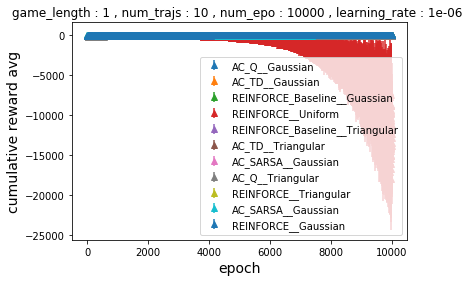

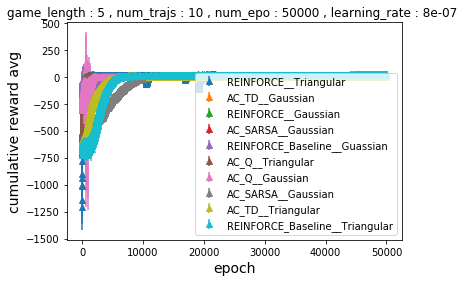

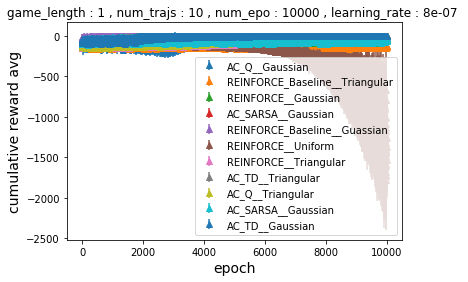

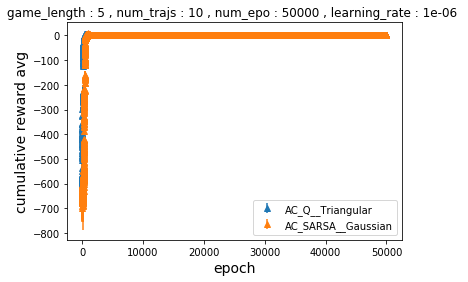

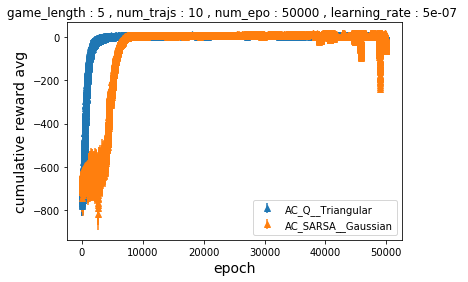

No handles with labels found to put in legend.


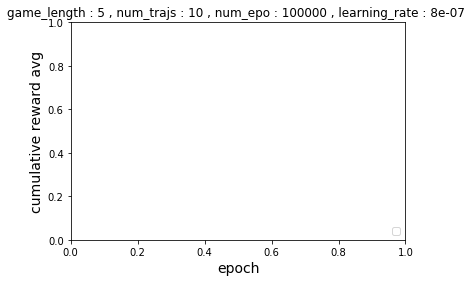

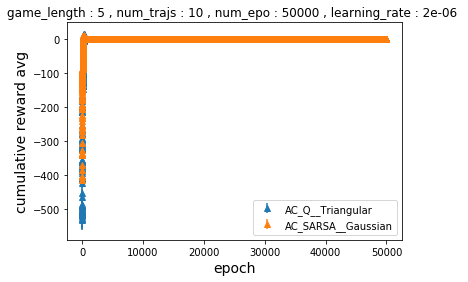

In [5]:
for elem in partition:
    Experiment.plot_one_elem_of_partition(elem, 
                                          ['game_length', 'num_trajs', 'num_epo', 'learning_rate'], 
                                          'algorithms_comparison')

In [6]:
partition = Experiment.partition_experiments(Experiment.equal_method_2, results_folder)
partition

[[exp_9__1_10_10000__1e-06__20200706192659.csv,
  exp_9__1_10_10000__8e-07__20200706192735.csv],
 [exp_11__5_10_50000__8e-07__20200706193009.csv],
 [exp_8__1_10_10000__1e-06__20200706192655.csv,
  exp_8__1_10_10000__8e-07__20200706192723.csv],
 [exp_8__5_10_50000__8e-07__20200706192832.csv,
  exp_8__5_10_50000__8e-07__20200706192615.csv],
 [exp_13__1_10_10000__8e-07__20200706192751.csv,
  exp_13__1_10_10000__1e-06__20200706192715.csv],
 [exp_6__1_10_10000__8e-07__20200706192636.csv,
  exp_6__1_10_10000__1e-06__20200706192647.csv],
 [exp_6__5_10_50000__8e-07__20200706192608.csv,
  exp_6__5_10_50000__8e-07__20200706192836.csv],
 [exp_7__1_10_10000__1e-06__20200706192651.csv,
  exp_7__1_10_10000__8e-07__20200706192640.csv],
 [exp_12__5_10_50000__8e-07__20200706192820.csv],
 [exp_7__5_10_50000__8e-07__20200706192612.csv,
  exp_7__5_10_50000__8e-07__20200706192839.csv],
 [exp_10__1_10_10000__1e-06__20200706192703.csv,
  exp_10__1_10_10000__8e-07__20200706192739.csv],
 [exp_15__5_10_50000__8

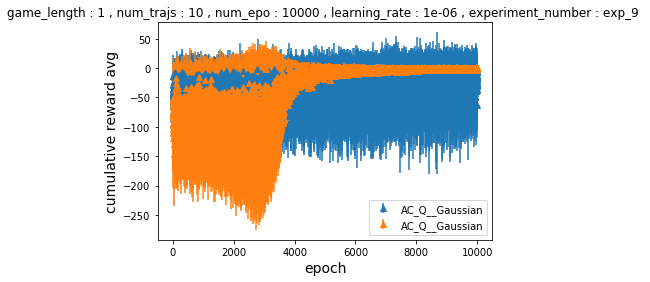

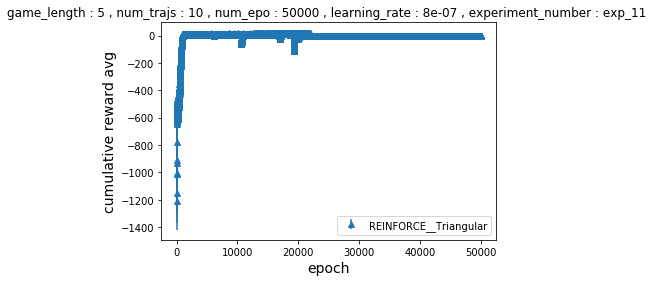

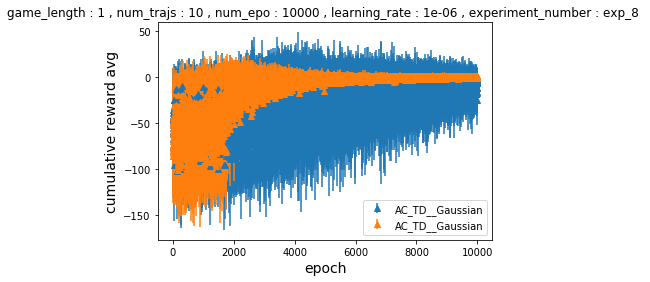

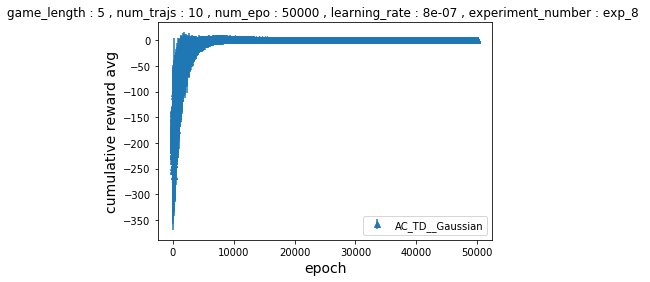

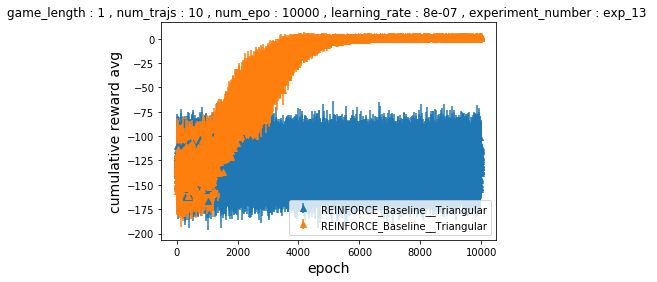

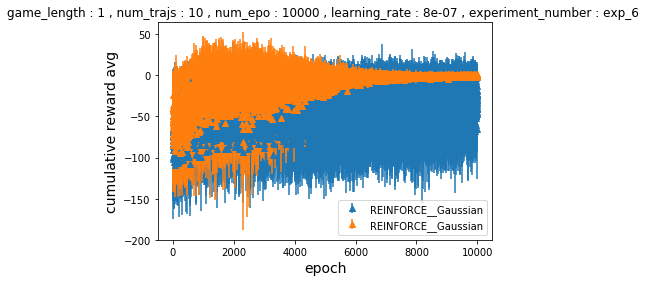

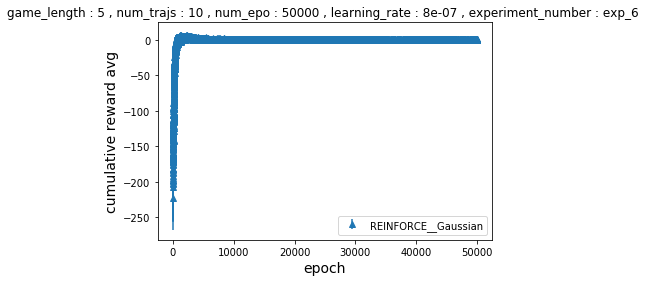

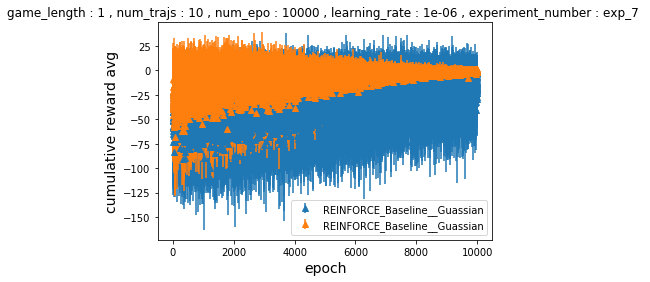

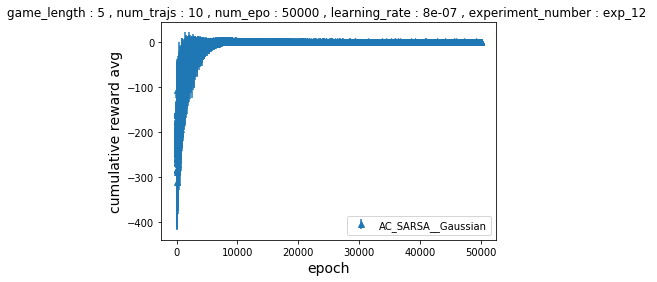

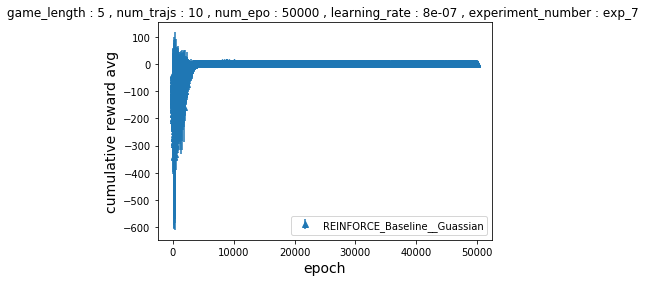

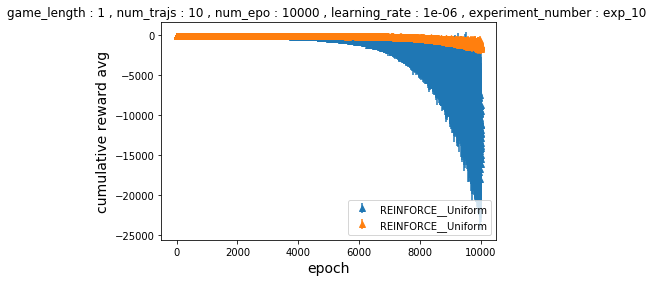

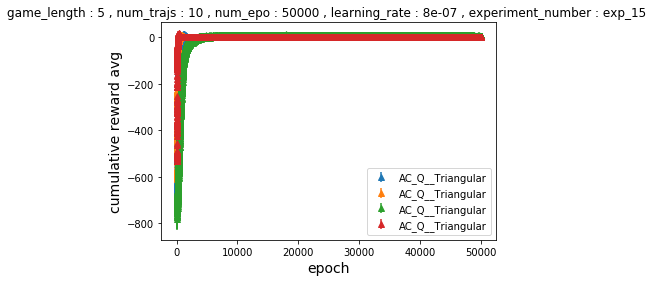

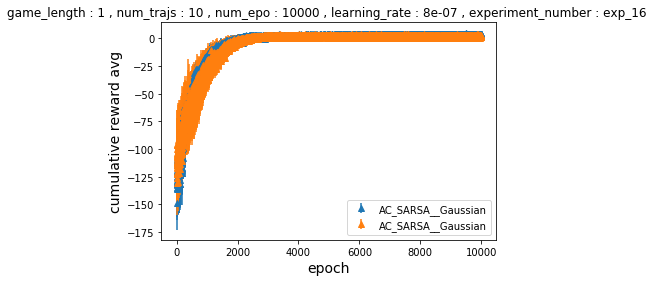

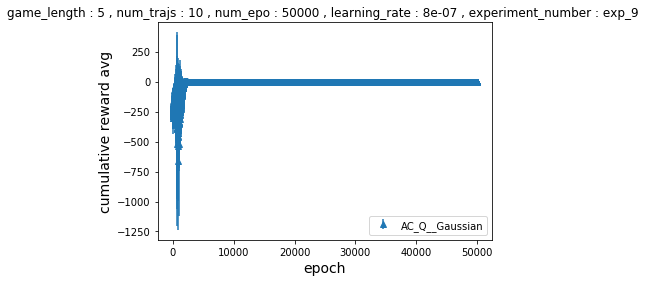

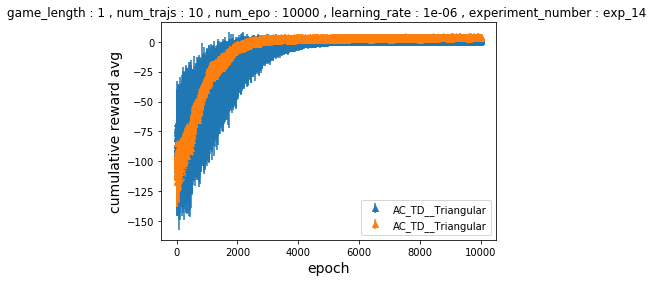

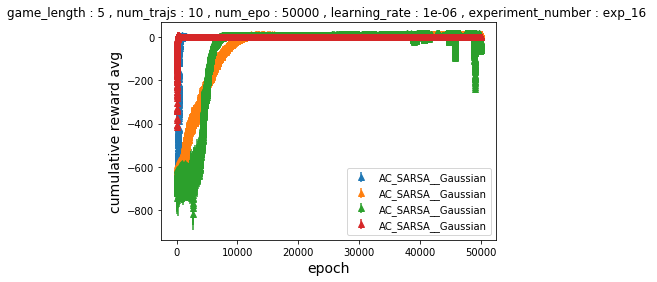

No handles with labels found to put in legend.


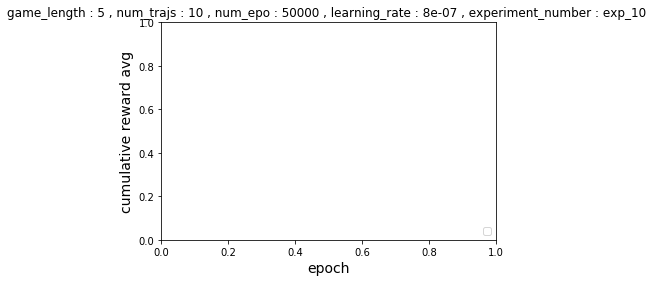

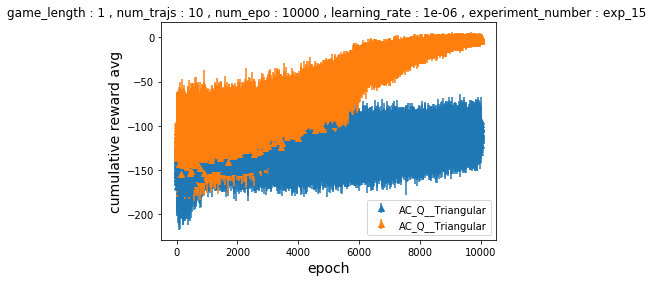

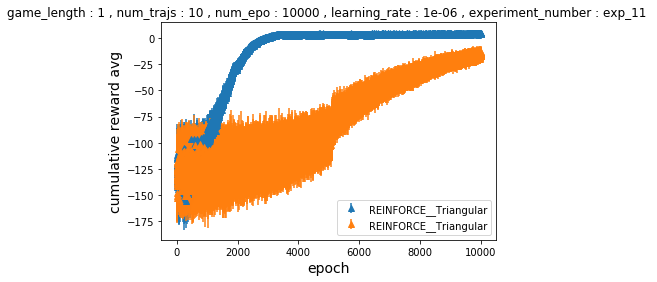

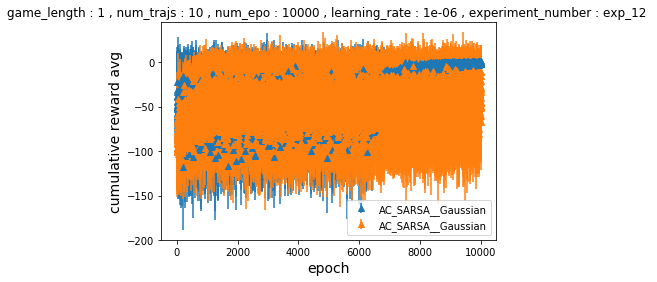

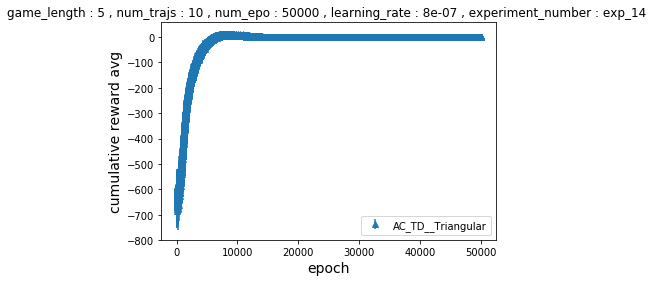

No handles with labels found to put in legend.


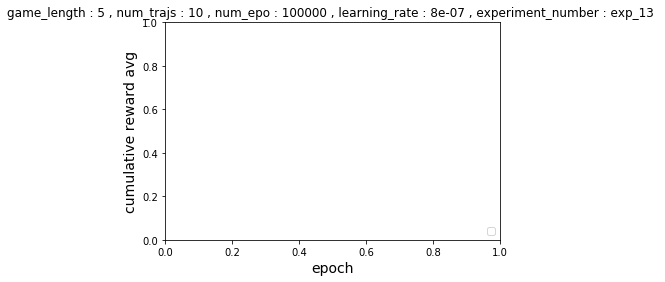

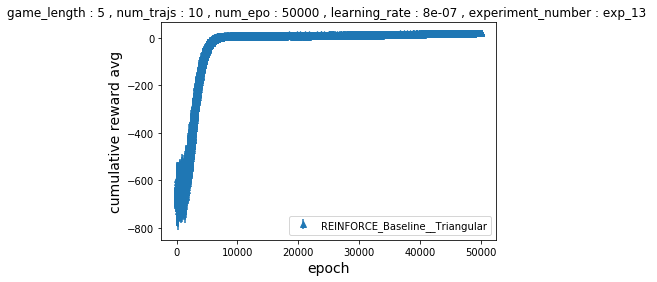

In [7]:
for elem in partition:
    Experiment.plot_one_elem_of_partition(elem, 
                                          ['game_length', 'num_trajs', 'num_epo', 'learning_rate', 'experiment_number'], 
                                          'learning_rates_comparison')